# Source selection for observing

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# read in ASKAP catalogue

data_1 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/AS102_Continuum_Island_Catalogue_10609_119.csv')
data_2 = pd.read_csv('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/AS102_Continuum_Island_Catalogue_10612_123.csv')

df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)

# concatenate catalogues
df = pd.concat([df_1, df_2])

In [3]:
df.keys()

Index(['id', 'catalogue_id', 'other_sbids', 'first_sbid', 'project_id',
       'island_id', 'island_name', 'n_components', 'ra_hms_cont',
       'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'freq', 'maj_axis',
       'min_axis', 'pos_ang', 'flux_int', 'flux_int_err', 'flux_peak',
       'mean_background', 'background_noise', 'max_residual', 'min_residual',
       'mean_residual', 'rms_residual', 'stddev_residual', 'x_min', 'x_max',
       'y_min', 'y_max', 'n_pix', 'solid_angle', 'beam_area', 'x_ave', 'y_ave',
       'x_cen', 'y_cen', 'x_peak', 'y_peak', 'flag_i1', 'flag_i2', 'flag_i3',
       'flag_i4', 'comment', 'quality_level', 'released_date'],
      dtype='object')

In [4]:
sources = df[df['flux_peak']>150]
print(len(sources))
ra = np.array(sources['ra_hms_cont'])
dec = np.array(sources['dec_dms_cont'])
F_peak = np.array(sources['flux_peak'])

48


In [7]:
cont_data = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Hydra_continuum/image.i.SB10612_v2.fits')  # Open the FITS file for reading
d_cont = cont_data[0].data
h_cont = cont_data[0].header
#d = d[0,0,:,:]

In [8]:
# read in HI data
hi_data = fits.open('/Users/denes/Research/high_lat_HI/GAS_data/gass_158_-28_Hydra_mom0.fits')  # Open the FITS file for reading
d = hi_data[0].data
h = hi_data[0].header
d = d[0,:,:]
del h['*3']
h['NAXIS'] = 2
c = 1.823 * 10**18
nhi = c*d

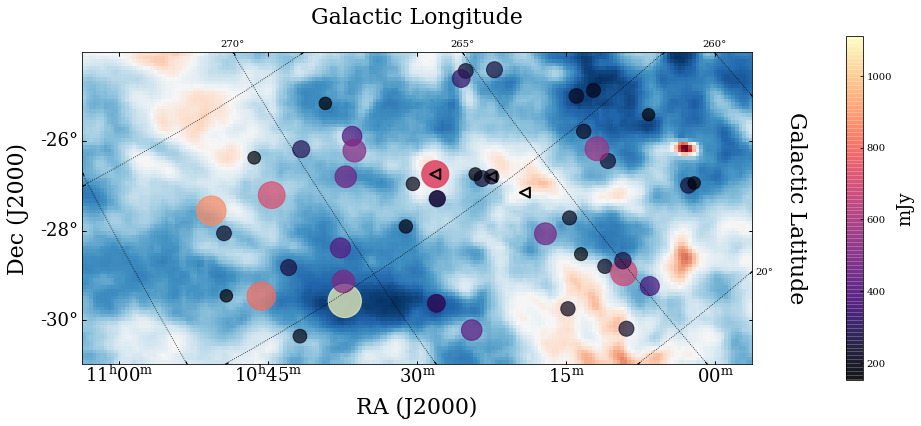

In [9]:
# make fancy HI overlay plots

# select continuum sources to plot

atca_sources = ['10:28:09.68 -26:44:18.9', '10:19:08.52 -27:08:56.5', '10:22:29.45 -26:47:34.3']

# plot figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(nhi, cmap='RdBu_r')
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

c_ra = []
c_dec = []

for i in range(0, len(ra)):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    c_ra.append(c_0.ra.value)
    c_dec.append(c_0.dec.value)

cb = ax.scatter(c_ra, c_dec, transform=ax.get_transform('fk5'), marker='o', s=F_peak, c =F_peak, cmap='magma', alpha=0.7)


for j in range(0, len(atca_sources)):
    c3 = SkyCoord(atca_sources[j], unit=(u.hourangle, u.deg))
    ax.scatter(c3.ra, c3.dec, transform=ax.get_transform('fk5'), marker='<', s=100, edgecolor='k', linewidth=2, facecolor='none')
    #ax.text(c3.ra.value, c3.dec.value, transform=ax.get_transform('fk5'),s=sources[j],fontsize=10)


#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

cbar_hi = plt.colorbar(cb, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('mJy', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#plt.colorbar(im)
fig.savefig('Hydra_ASKAP_continuum_sources_obs.png',dpi=200)

In [10]:
sources_5sig = pd.read_csv('./5_sigma_askap_sources.csv')
ra_5s = np.array(sources_5sig['ra_hms_cont'])
dec_5s = np.array(sources_5sig['dec_dms_cont'])

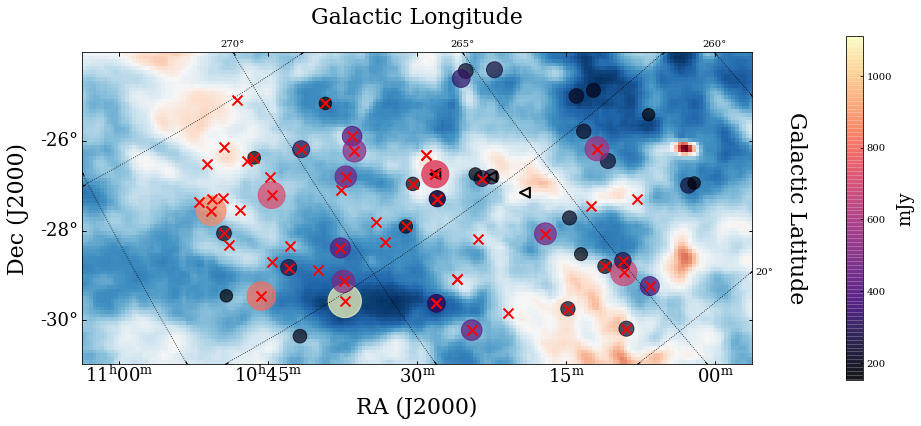

In [11]:
# make fancy HI overlay plots

# select continuum sources to plot

atca_sources = ['10:28:09.68 -26:44:18.9', '10:19:08.52 -27:08:56.5', '10:22:29.45 -26:47:34.3']

# plot figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(nhi, cmap='RdBu_r')
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

c_ra = []
c_dec = []

for i in range(0, len(ra)):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    c_ra.append(c_0.ra.value)
    c_dec.append(c_0.dec.value)

cb = ax.scatter(c_ra, c_dec, transform=ax.get_transform('fk5'), marker='o', s=F_peak, c =F_peak, cmap='magma', alpha=0.7)


for j in range(0, len(atca_sources)):
    c3 = SkyCoord(atca_sources[j], unit=(u.hourangle, u.deg))
    ax.scatter(c3.ra, c3.dec, transform=ax.get_transform('fk5'), marker='<', s=100, edgecolor='k', linewidth=2, facecolor='none')
    #ax.text(c3.ra.value, c3.dec.value, transform=ax.get_transform('fk5'),s=sources[j],fontsize=10)

for i in range(0, len(ra_5s)):
    coord = '{} {}'.format(ra_5s[i], dec_5s[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='r', linewidth=2, facecolor='r')


#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

cbar_hi = plt.colorbar(cb, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('mJy', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#plt.colorbar(im)
fig.savefig('Hydra_ASKAP_continuum_sources_obs_5sig.png',dpi=200)

## Make continuum image cutouts to check sources

48
INFO: Auto-setting vmin to -4.388e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.278e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.661e-04 [aplpy.core]
INFO: Auto-setting vmax to  6.307e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.491e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.462e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.368e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.422e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.539e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.028e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.841e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.602e-04 [aplpy.core]
INFO: Auto-setting vmin to -5.010e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.258e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.541e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.497e-04 [aplpy.core]
INFO: Auto-setting vmin to -4.568e-04 [aplpy.core]
INFO: Auto-setting vmax to  5.825e-04 [aplpy.core]


KeyboardInterrupt: 

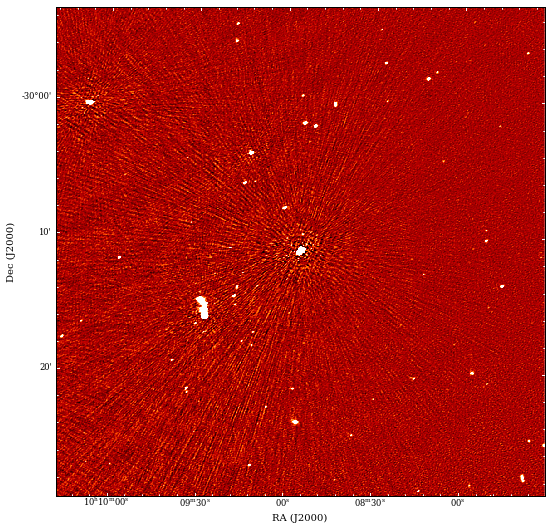

In [12]:
#gc = aplpy.FITSFigure('/Users/denes/Research/high_lat_HI/ASKAP_data/Hydra_continuum/image.i.SB10612_v2.fits')
gc = aplpy.FITSFigure('/Users/denes/Research/high_lat_HI/ASKAP_data/Hydra_continuum/image.i.SB10269_v2.fits')

print(len(ra))

for i in range(0, 27):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    gc.recenter(c_0.ra.deg, c_0.dec.deg, radius=0.3)
    #gc.show_circles(c_0.ra.deg, c_0.dec.deg, 0.008, color='cyan', linewidth=2)

    gc.show_colorscale(cmap='gist_heat')
    gc.tick_labels.set_font(size='small')
    gc.recenter(c_0.ra.deg, c_0.dec.deg, radius=0.3)

    gc.save('test_{}.png'.format(i))

In [13]:
print(sources.keys())
source_list = sources[['ra_hms_cont', 'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'flux_int', 'flux_peak', 'maj_axis', 'n_pix']]
source_list.to_csv('./bright_ASKAP_source_list.csv')


Index(['id', 'catalogue_id', 'other_sbids', 'first_sbid', 'project_id',
       'island_id', 'island_name', 'n_components', 'ra_hms_cont',
       'dec_dms_cont', 'ra_deg_cont', 'dec_deg_cont', 'freq', 'maj_axis',
       'min_axis', 'pos_ang', 'flux_int', 'flux_int_err', 'flux_peak',
       'mean_background', 'background_noise', 'max_residual', 'min_residual',
       'mean_residual', 'rms_residual', 'stddev_residual', 'x_min', 'x_max',
       'y_min', 'y_max', 'n_pix', 'solid_angle', 'beam_area', 'x_ave', 'y_ave',
       'x_cen', 'y_cen', 'x_peak', 'y_peak', 'flag_i1', 'flag_i2', 'flag_i3',
       'flag_i4', 'comment', 'quality_level', 'released_date'],
      dtype='object')


In [ ]:
print(h_cont['BMAJ']*3600, h_cont['BMIN']*3600)

# Make source list based on ra and dec

In [14]:
source_list_1 = source_list[source_list['dec_deg_cont']<-28.6]
source_list_1 = source_list_1[source_list_1['ra_deg_cont']<154]
ra_1 = np.array(source_list_1['ra_hms_cont'])
dec_1 = np.array(source_list_1['dec_dms_cont'])
source_list_1

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
1147,10:08:55.2,-30:11:12,152.230160,-30.186719,583.534,227.038,32.89,267
1195,10:11:05.5,-28:47:40,152.772952,-28.794449,221.762,202.523,8.37,126
1489,10:09:11.1,-28:55:53,152.296138,-28.931468,1666.703,694.487,18.70,259
1490,10:14:48.6,-29:44:33,153.702616,-29.742508,231.807,205.575,9.86,185
4698,10:06:34.2,-29:14:06,151.642301,-29.235252,477.294,365.438,9.51,240
9519,10:09:16.5,-28:40:06,152.318738,-28.668506,328.435,271.068,10.15,217


In [15]:
source_list_2 = source_list[source_list['dec_deg_cont']<-27.8]
source_list_2 = source_list_2[source_list_2['ra_deg_cont']>155]
source_list_2 = source_list_2[source_list_2['ra_deg_cont']<159.5]
ra_2 = np.array(source_list_2['ra_hms_cont'])
dec_2 = np.array(source_list_2['dec_dms_cont'])
source_list_2

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
3734,10:24:29.6,-30:13:03,156.123328,-30.217509,493.745,426.476,9.77,128
7662,10:28:02.9,-29:37:10,157.012212,-29.619631,449.912,308.885,11.00,252
52,10:37:16.1,-29:34:02,159.316947,-29.567471,1206.117,1109.796,9.03,177
145,10:28:02.9,-29:37:11,157.012225,-29.619752,458.179,312.936,13.05,199
967,10:31:07.3,-27:54:15,157.780209,-27.904429,223.295,179.085,9.31,198
6582,10:37:23.8,-29:07:54,159.349010,-29.131702,814.230,508.234,14.07,150
8914,10:37:42.5,-28:23:04,159.426883,-28.384494,457.801,407.463,8.47,139


In [16]:
source_list_3 = source_list[source_list['dec_deg_cont']<-27.2]
source_list_3 = source_list_3[source_list_3['dec_deg_cont']>-30]
source_list_3 = source_list_3[source_list_3['ra_deg_cont']>159.5]
ra_3 = np.array(source_list_3['ra_hms_cont'])
dec_3 = np.array(source_list_3['dec_dms_cont'])
source_list_3

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
410,10:42:55.3,-28:49:17,160.730400,-28.821655,404.965,258.492,13.11,189
547,10:50:42.4,-27:33:09,162.676639,-27.552548,996.090,873.144,8.59,260
548,10:49:11.4,-29:27:11,162.297452,-29.453201,182.127,155.671,8.34,192
614,10:49:25.6,-28:03:26,162.356746,-28.057409,241.396,217.951,8.55,204
1694,10:45:40.6,-29:27:26,161.419373,-29.457405,963.967,812.210,8.39,197
4508,10:44:37.7,-27:12:18,161.157015,-27.205269,793.226,720.798,8.34,173


In [17]:
source_list_4 = source_list[source_list['dec_deg_cont']>-27]
source_list_4 = source_list_4[source_list_4['ra_deg_cont']>158]
ra_4 = np.array(source_list_4['ra_hms_cont'])
dec_4 = np.array(source_list_4['dec_dms_cont'])
source_list_4

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
2,10:41:39.3,-26:10:52,160.413596,-26.181133,303.781,291.379,9.36,183
53,10:36:31.9,-25:53:19,159.132730,-25.888721,411.360,386.440,8.61,182
311,10:46:23.2,-26:22:17,161.596818,-26.371534,185.120,161.325,8.48,116
1412,10:39:13.5,-25:09:28,159.806151,-25.157961,365.160,155.609,20.64,261
5708,10:36:18.2,-26:12:47,159.075709,-26.213083,560.310,522.060,9.40,185
7756,10:37:10.3,-26:47:40,159.292716,-26.794652,482.597,465.812,8.50,179


In [18]:
source_list_5 = source_list[source_list['dec_deg_cont']>-27.5]
source_list_5 = source_list_5[source_list_5['ra_deg_cont']<154]
source_list_5 = source_list_5[source_list_5['ra_deg_cont']>151.5]

ra_5 = np.array(source_list_5['ra_hms_cont'])
dec_5 = np.array(source_list_5['dec_dms_cont'])
source_list_5

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
61,10:10:47.0,-26:26:34,152.695687,-26.442819,275.825,230.337,9.06,200
381,10:13:13.1,-25:46:54,153.304631,-25.781721,225.787,209.996,9.07,204
1408,10:12:14.5,-24:52:01,153.060266,-24.866964,280.160,198.049,12.67,228
1675,10:13:57.8,-24:59:32,153.490824,-24.992467,262.784,214.344,8.31,211
1842,10:06:41.7,-25:24:36,151.673910,-25.410079,179.243,152.089,9.19,135
2057,10:11:53.8,-26:10:15,152.974073,-26.170857,851.138,568.857,10.44,248


In [27]:
source_list_6 = source_list[source_list['dec_deg_cont']<-26.]
source_list_6 = source_list_6[source_list_6['dec_deg_cont']>-28.6]
source_list_6 = source_list_6[source_list_6['ra_deg_cont']>154]
source_list_6 = source_list_6[source_list_6['ra_deg_cont']<157]

ra_6 = np.array(source_list_6['ra_hms_cont'])
dec_6 = np.array(source_list_6['dec_dms_cont'])
source_list_6

,ra_hms_cont,dec_dms_cont,ra_deg_cont,dec_deg_cont,flux_int,flux_peak,maj_axis,n_pix
230,10:23:27.1,-26:50:09,155.863051,-26.835962,277.048,250.805,9.87,166
273,10:27:57.7,-27:17:09,156.990362,-27.285888,702.601,246.479,17.75,390
1564,10:22:29.5,-26:47:34,155.622859,-26.792925,243.951,217.652,8.89,185
2311,10:24:07.4,-26:44:17,156.030852,-26.738172,177.432,166.763,9.32,144
3565,10:17:04.6,-28:04:04,154.269176,-28.068007,605.412,478.062,9.17,215
698,10:27:57.7,-27:17:09,156.990399,-27.285989,734.294,263.941,17.82,320


In [ ]:
source_list_1.to_csv('./bright_ASKAP_source_list_1.csv')
source_list_2.to_csv('./bright_ASKAP_source_list_2.csv')
source_list_3.to_csv('./bright_ASKAP_source_list_3.csv')
source_list_4.to_csv('./bright_ASKAP_source_list_4.csv')
source_list_5.to_csv('./bright_ASKAP_source_list_5.csv')


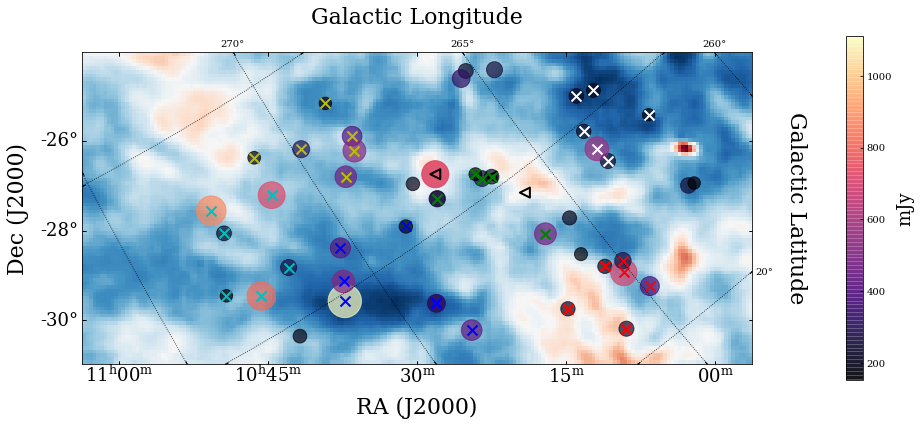

In [28]:
# make fancy HI overlay plots

# select continuum sources to plot

atca_sources = ['10:28:09.68 -26:44:18.9', '10:19:08.52 -27:08:56.5', '10:22:29.45 -26:47:34.3']

# plot figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection=WCS(h))

# Display the moment map image
im = ax.imshow(nhi, cmap='RdBu_r')
#ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

c_ra = []
c_dec = []

for i in range(0, len(ra)):
    coord = '{} {}'.format(ra[i], dec[i])
    c_0 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    c_ra.append(c_0.ra.value)
    c_dec.append(c_0.dec.value)

cb = ax.scatter(c_ra, c_dec, transform=ax.get_transform('fk5'), marker='o', s=F_peak, c =F_peak, cmap='magma', alpha=0.7)


for j in range(0, len(atca_sources)):
    c3 = SkyCoord(atca_sources[j], unit=(u.hourangle, u.deg))
    ax.scatter(c3.ra, c3.dec, transform=ax.get_transform('fk5'), marker='<', s=100, edgecolor='k', linewidth=2, facecolor='none')
    #ax.text(c3.ra.value, c3.dec.value, transform=ax.get_transform('fk5'),s=sources[j],fontsize=10)

for i in range(0, len(ra_1)):
    coord = '{} {}'.format(ra_1[i], dec_1[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='r', linewidth=2, facecolor='r')

for i in range(0, len(ra_2)):
    coord = '{} {}'.format(ra_2[i], dec_2[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='b', linewidth=2, facecolor='b')

for i in range(0, len(ra_3)):
    coord = '{} {}'.format(ra_3[i], dec_3[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='c', linewidth=2, facecolor='c')

for i in range(0, len(ra_4)):
    coord = '{} {}'.format(ra_4[i], dec_4[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='y', linewidth=2, facecolor='y')

for i in range(0, len(ra_5)):
    coord = '{} {}'.format(ra_5[i], dec_5[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='w', linewidth=2, facecolor='w')

for i in range(0, len(ra_6)):
    coord = '{} {}'.format(ra_6[i], dec_6[i])
    c_1 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c_1.ra, c_1.dec, transform=ax.get_transform('fk5'), marker='x', s=100, edgecolor='g', linewidth=2, facecolor='g')
     
#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

cbar_hi = plt.colorbar(cb, orientation='vertical', fraction=0.022, pad=0.12)
cbar_hi.set_label('mJy', size=18)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
overlay[1].set_axislabel('Galactic Latitude', fontsize=22)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

#plt.colorbar(im)
fig.savefig('Hydra_ASKAP_continuum_sources_obs_5sig_v2.png',dpi=200)